## Imports

In [114]:
import logging
import random
from pathlib import Path
from collections.abc import Iterable

import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from PIL import Image

In [25]:
sns.set()
sns.set_style("whitegrid", {'axes.grid' : False})
logger = logging.getLogger()

## Psbeam

https://github.com/slaclab/psbeam

In [8]:
# beamexceptions.py

class BeamException(Exception):
    """
    Base exception class for psbeam.
    """
    def __init__(self, msg='', *args, **kwargs):
        self.msg = msg
        super().__init__(*args, **kwargs)

    def __str__(self):
        logger.error(self.msg, stack_info=True)
        return repr(self.msg)

class InputError(BeamException):
    """
    Generic exception raised if an invalid input was used.
    """
    pass

class NoContoursDetected(BeamException):
    """
    Error raised if an operation requiring contours is requested but no contours
    were returned by the get_contours function.
    """
    def __init__(self, msg='', *args, **kwargs):
        if not msg:
            msg = "Cannot perform operation; No contours found."
        super().__init__(msg=msg, *args, **kwargs)

class NoBeamDetected(BeamException):
    """
    Exception raised if an operation requiring the beam is requested but no beam
    is actually present.
    """
    def __init__(self, msg='', *args, **kwargs):
        if not msg:
            msg = "Cannot perform operation; No beam found."
        super().__init__(msg=msg, *args, **kwargs)

        
class MomentOutOfRange(BeamException):
    """
    Exception raised a beam moment is out of its designated range.
    """
    def __init__(self, msg='', *args, **kwargs):
        if not msg:
            msg = "Moment is out of specified range."
        super().__init__(msg=msg, *args, **kwargs)

In [9]:
# preprocessing.py

def to_gray(image, color_space="RGB", cv2_color=None):
    """
    Converts the inputted image to gray scale.

    This function should serve as a wrapper for cv2.cvtColor with basic input
    checking. Its main use is to convert color images to gray scale but it can
    be used as an alias to cv2.cvtColor if a color conversion code is passed
    into cv2_color

    Parameters
    ----------
    image : np.ndarray
        Image to convert to grayscale.

    color_space : str, optional
        Color space of the image. Valid entries are 'RGB', 'BGR'.

    cv2_color : cv2.ColorConversionCodes
        OpenCV color conversion code. Bypasses image array checks if used.

    Returns
    -------
    image_gray : np.ndarray
        The image converted to gray scale (ie len(image.shape) is 2)

    Raises
    ------
    InputError
        If input is not an image or color_space is invalid.
    """
    # Check if an OpenCV color conversion was entered
    if cv2_color is not None:
        color = cv2_color
        
    else:
        # Check we are getting an image
        if len(image.shape) < 2:
            raise InputError("Got array that is not an image. Shape is {0}."
                             "".format(image.shape))

        # Check that it isn't already grayscale
        if len(image.shape) < 3:
            logger.warning("Got image that is already grayscale.")
            return image

        # Check for the color space
        if color_space.upper() == "RGB":
            color = cv2.COLOR_RGB2GRAY
        elif color_space.upper() == "BGR":
            color = cv2.COLOR_BGR2GRAY
        else:
            raise InputError("Invalid color_space entry. Got '{0}'".format(
                color_space))

    # Do the conversion
    return cv2.cvtColor(image, color)

def to_uint8(image, mode="scale"):
    """
    *Correctly* converts an image to uint8 type.
    
    Running 'image.astype(np.uint8)' on its own applies a mod(256) to handle
    values over 256. The correct way is to either clip (implemented here) or
    normalize to the the max and min possible values of the array. Below are the
    available conversion modes:

    clip
        Truncates the  image at 0 and 255, then returns the resulting array.

    norm
        Normalizes the image so that the maximum value of the input array is set
        to 255 and the minimum value is 0.
    
    scale
        Scales the image so that the maximum and minimum values of the resulting
        array corresponds to the maximum and minimum possible values of the
        input array.

    Parameters
    ----------
    image : np.ndarray
        Image to be converted to uint8.

    mode : str, optional 
        Conversion mode to use. See conversion modes for more details.

    Returns
    -------
    np.ndarray
        Image that is a np.ndarray with dtype uint8.
    """
    # The main hurdle with performing the clipping is making sure we don't
    # create values that exceed the buffer size of the inputted dtype. For
    # example, for float32 the maximum value is 65504.0 and the min value is
    # 65504.0. If you try to find the range using a float32 by doing 65504.0 -
    # (-65504.0) you will get Inf.
    
    # Make sure the image is a numpy array
    if not isinstance(image, np.ndarray):
        image_array = np.array(image)
    else:
        image_array = np.copy(image)
        
    # Clip or normalize the image
    if mode.lower() == "clip":
        output = np.clip(image_array, 0, 255)

    # Normalize to max and min values of the array
    elif mode.lower() == "norm":
        range_pixels = image_array.max() - image_array.min() or 1        
        output = 255 * (image_array - image_array.min()) / range_pixels
        
    # Scale according to the max and min possible values of the array
    elif mode.lower() == "scale":
        try:
            # Grab array info for int types
            type_min = np.iinfo(image_array.dtype).min
            type_max = np.iinfo(image_array.dtype).max
        except ValueError:
            # Grab array info for float types
            type_min = np.finfo(image_array.dtype).min
            type_max = np.finfo(image_array.dtype).max
        # Use half the range to guarantee we can fit the range in the variable
        range_half = type_max/2 - type_min/2
        output = ((image_array/2 - type_min/2)/range_half) * 255

    # Handle invalid inputs
    else:
        raise InputError("Invalid conversion mode inputted. Valid modes are " 
                         "'clip' and 'norm.'")

    # Warn the user if the preprocessing resulted in a zeroed array
    if not output.any() and image_array.any():
        logger.warning("to_uint8 resulted in a fully zeroed array from "
                       "non-zero input.")

    # Return casting as uint8
    return output.astype(np.uint8)

def uint_resize_gauss(image, mode='scale', fx=1.0, fy=1.0, kernel=(11,11), 
                      sigma=0):
    """
    Preprocess the image by converting to uint8, resizing and running a 
    gaussian blur.
    
    Parameters
    ----------
    image : np.ndarray
        The image to be preprocessed.

    mode : str, optional 
        Conversion mode that either clips the image or normalizes to the range
        of the original image type.

    fx : float, optional
        Percent to resize the image by in x.

    fy : float, optional
        Percent to resize the image by in y.

    kernel : tuple, optional
        Kernel to use when running the gaussian filter.

    Returns
    -------
    np.ndarray 
        Image of type uint8 that has been resized and blurred.
    """
    image_uint = to_uint8(image, mode=mode)
    image_resized = cv2.resize(image_uint, (0,0), fx=fx, fy=fy)
    image_gblur = cv2.GaussianBlur(image_resized, kernel, sigma)
    return image_gblur

def threshold_image(image, binary=True, mode="top", factor=1, **kwargs):
    """
    Thresholds the image, creating a binary image.

    The thresholding can be done using one of the following modes:

    mean
        Set the threshold line to be image.mean + image.std*factor.

    top
        Sets the threshold line to be image.max - image.std*factor, leaving just
        the highest intensity pixels.

    bottom
        Sets the threshold line to be image.min + image.std*factor, removing
        just the lowest intensity pixels

    adaptive
        Sets threshold line according to a weighed sum of neughborhood values
        using a gaussian window. See 'Adaptive Thresholding' in the following
        link for more details.
        http://docs.opencv.org/trunk/d7/d4d/tutorial_py_thresholding.html

    otsu
        Sets the threshold to be between the histogram peaks of a bimodal image.
        See "Otsu's Binarization" in the following for more details.
        http://docs.opencv.org/trunk/d7/d4d/tutorial_py_thresholding.html

    Parameters
    ----------
    image : np.ndarray
        The image to threshold.

    binary : bool, optional
        Use binary thresholding or to_zero thresholding.

    mode : str, optional
        Thresholding mode to use. See docstring for more information.

    factor : int, optional
        Number of times to multiply the std by before adding to the mean for
        thresholding.    
        
    Returns
    -------
    th : np.ndarray
        Image that has been thresholded.
    """
    valid_modes = set(['mean', 'top', 'bottom', 'adaptive', 'otsu'])
    if binary:
        th_type = cv2.THRESH_BINARY
    else:
        th_type = cv2.THRESH_TOZERO

    # Find the right mode
    if mode.lower() not in valid_modes:
        raise InputError("Invalid mode passed for thresholding.")
    elif mode.lower() == 'mean':
        _, th = cv2.threshold(image, image.mean() + image.std()*factor, 
                              255,
                              th_type)        
    elif mode.lower() == 'top':
        _, th = cv2.threshold(image, image.max() - image.std()*factor, 
                              255,
                              th_type)
    elif mode.lower() == 'bottom':
        _, th = cv2.threshold(image, image.min() + image.std()*factor, 
                              255,
                              th_type)
    elif mode.lower() == "adaptive":
        blockSize = kwargs.pop("BlockSize", 11)
        C = kwargs.pop("C", 2)        
        th = cv2.adaptiveThreshold(image, 
                                   255, 
                                   cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   th_type, 
                                   blockSize, 
                                   C)
    elif mode.lower() == "otsu":
        _, th = cv2.threshold(image, 0, 255, th_type+cv2.THRESH_OTSU)

    return th

In [10]:
# utils.py

def isiterable(obj):
    """
    Function that determines if an object is an iterable, not including 
    str.

    Parameters
    ----------
    obj : object
        Object to test if it is an iterable.

    Returns
    -------
    bool : bool
        True if the obj is an iterable, False if not.
    """
    if isinstance(obj, str):
        return False
    else:
        return isinstance(obj, Iterable)

def rolling_average (values, window):
    weights = np.repeat(1.0, window)/window
    return np.convolve(values, weights, 'valid')

def plot_image(image,  msg = ""):
    """
    Plots an image with an optional message.
    """
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(image)
    if msg:
        plt.text(0.95, 0.05, msg, ha='right', va='center', color='w',
                transform=ax.transAxes)
    plt.grid()
    plt.show()

def get_images_from_dir(target_dir, n_images=None, shuffle=False, out_type=list,
                        recursive=False, read_mode=cv2.IMREAD_UNCHANGED,
                        glob="*"):
    """
    Crawls through the contents of inputted directory and saves files with 
    image extensions as images.
    """
    image_ext = set(["bmp", "jpeg", "jpg", "png", "tif", "tiff"])
    target_dir_path = Path(target_dir)
    if recursive and glob == "*":
        glob = "**"
    # Grab path of all image files in dir
    image_paths = [p for p in sorted(target_dir_path.glob(glob)) if
                   p.is_file() and p.suffix[1:].lower() in image_ext]
    
    # Shuffle the list of paths
    if shuffle:
        random.shuffle(image_paths)
        if out_type is dict:
            logger.warning("Shuffle set to True for requested output type dict")
    # Only keep n_images of those files
    if n_images:
        image_paths = image_paths[:n_images]

    # Return as the desired type
    if out_type is dict:
        return {p.stem : cv2.imread(str(p), read_mode) for p in image_paths}
    else:
        return out_type([cv2.imread(str(p), read_mode) for p in image_paths])
        
def signal_tuple(signal, remove_zero=True, raise_zero=True, cast=int):
    """
    Returns a tuple from the return value of the signal.
    """
    tup = [cast(val) for val in signal.get()]
    
    # Check the tuple isn't all zeros if raise_zero is true
    if raise_zero and all(val == 0 for val in tup):
        raise ValueError("Invalid tuple. Ensure callbacks are on.")
    
    # Remove the trailing zeros if remove_zero is true
    if remove_zero:
        idx = 1
        while True:
            if tup[-idx] != 0:
                tup = tup[:-idx+1]
                break
            idx += 1

    # Make sure a vector wasn't passed
    if raise_zero and 0 in tup:
        raise ValueError("Invalid tuple value. Contains 0 for value that isn't "
                         "trailing.")
    return tup

def to_image(array, size_signal=None, shape=None,
             uint_mode="clip"):
    """
    Tries to convert the inputted array into an image format.
    """
    # Check that we can get an image shape
    if size_signal:
        shape = signal_tuple(size_signal)
    elif not shape:
        raise InputError("Must input either a signal or expected array shape "
                         "to convert array to an image.")
        
    return to_uint8(array.reshape(shape), mode=uint_mode)

In [11]:
# contouring.py

def get_contours(image, thresh_mode="otsu", *args, **kwargs):
    """
    Returns the contours of an image according to the inputted threshold.

    Parameters
    ----------
    image : np.ndarray
        Image to extract the contours from.

    thresh_mode : str, optional
        Thresholding mode to use. For extended documentation see
        ``preprocessing.threshold_image``. Valid modes are:
            ['mean', 'top', 'bottom', 'adaptive', 'otsu']

    Returns
    -------
    contours : list
        A list of the contours found in the image.

    Raises
    ------
    NoContoursDetected
        The returned contours list was empty.
    """
    image_thresh = threshold_image(image, mode=thresh_mode, **kwargs)
    _, contours, _ = cv2.findContours(image_thresh, 1, 2)    
    # Check if contours is empty
    if not contours:
        raise NoContoursDetected
    return contours

def get_largest_contour(image=None, contours=None, thresh_mode="otsu",
                        **kwargs):
    """
    Returns largest contour of the contour list. Either an image or a contour
    must be passed. If both are passed, a warning will be logged and the
    contours of the image will be computed and used to find the largest contour.

    Function is making an implicit assumption that there will only be one
    (large) contour in the image. 

    Parameters
    ----------
    image : np.ndarray, optional
        Image to extract the contours from.

    contours : np.ndarray, optional
        Contours found on an image.

    thresh_mode : str, optional
        Thresholding mode to use. For extended documentation see
        ``preprocessing.threshold_image``. Valid modes are:
            ['mean', 'top', 'bottom', 'adaptive', 'otsu']
    
    Returns
    -------
    (contour_largest, area_largest) : tuple
        Contour that encloses the largest area and the area it encloses

    Raises
    ------
    InputError
        If neither an image nor contours are inputted, or largest area is zero
    """
    # Check if contours were inputted
    if image is None and contours is None:
        raise InputError("No image or contours provided.")
    elif image is not None:
        if contours is not None:
            logger.warning("Image and contours inputted. Returning largest "
                           "contour of the image.")
        contours = get_contours(image, thresh_mode=thresh_mode, **kwargs)
        
    # Get area of all the contours found
    areas = np.array([cv2.contourArea(cnt) for cnt in contours])
    # Largest contour and its area
    contour_largest = contours[np.argmax(areas)]
    area_largest = areas.max()

    # Last check to make sure the area is nonzero:
    if area_largest == 0.0:
        raise NoContoursDetected
    
    # Return argmax and max
    return contour_largest, area_largest

def get_moments(image=None, contour=None, **kwargs):
    """
    Returns the moments of an image.

    Attempts to find the moments using an inputted contours first, but if it
    isn't inputted it will compute the contours of the image then compute
    the moments.

    Parameters
    ----------
    image : np.ndarray
        Image to calculate moments from.

    contour : np.ndarray
        Beam contour.

    Returns
    -------
    moments : dict
        Dictionary with all the calculated moments of the image.

    Raises
    ------
    InputError
        If neither an image nor contours are inputted.    
    """
    if image is None and contour is None:
        raise InputError("No image or contour provided.")
    elif image is not None:
        if contour is not None:
            logger.warning("Image and contour inputted. Using largest contour "
                        "of the image.")
        contour, _ = get_largest_contour(image, **kwargs)
        
    return cv2.moments(contour)
        
def get_centroid(M):
    """
    Returns the centroid using the inputted image moments.

    Centroid is computed as being the first moment in x and y divided by the
    zeroth moment.

    Parameters
    ----------
    M : list
        List of image moments.
    
    Returns
    -------
    tuple
        Centroid of the image moments.
    """    
    return int(M['m10']/M['m00']), int(M['m01']/M['m00'])

def get_bounding_box(image=None, contour=None, **kwargs):
    """
    Finds the up-right bounding box that contains the inputted contour. Either
    an image or contours have to be passed.

    Parameters
    ----------
    image : np.ndarray
        Image to calculate moments from.

    contour : np.ndarray
        Beam contour.

    Returns
    -------
    tuple
        Contains x, y, width, height of bounding box.

    It should be noted that the x and y coordinates are for the bottom left
    corner of the bounding box. Use matplotlib.patches.Rectangle to plot.
    """
    if image is None and contour is None:
        raise InputError("No image or contour provided.")
    elif image is not None:
        if contour is not None:
            logger.warning("Image and contour inputted. Using largest contour "
                        "of the image.")
        contour, _ = get_largest_contour(image, **kwargs)
        
    return cv2.boundingRect(contour)

def get_contour_size(image=None, contour=None, **kwargs):
    """
    Returns the length and width of the contour, or the contour of the image
    inputted.

    Parameters
    ----------
    image : np.ndarray
        Image to calculate moments from.

    contour : np.ndarray
        Beam contour.

    Returns
    -------
    tuple
        Length and width of the inputted contour.

    Raises
    ------
    InputError
        If neither an image nor contours are inputted.    
    """
    _, _, w, l = get_bounding_box(image=image, contour=contour, **kwargs)
    return l, w

In [72]:
def get_opening(image, n_erode=1, n_dilate=1, kernel=(5,5)):
    """
    Performs the specified number of erosions, followed by the specified number
    of dilations to get the opening of the image.

    Parameters
    ----------
    image : np.ndarray
        The image to perform the opening on. Must be a binary image

    n_erode : int, optional
        The number of times to perform an erosion on the image.

    n_dilate : int, optional
        The number of times to perform a dilation on the image.

    kernel : tuple, optional
        The kernel size to use when eroding and dilating.

    Returns
    -------
    image_opened : np.ndarray
        Image that has had n_erode erosions followed by n_dilate dilations.

    Raises
    ------
    InputError
        When image passed is not a binary image
    """
    # Check that image is binary
    if len(np.unique(image)) > 2:
        raise InputError("Binary image is required for morphological "
                         "transformations.")
    kernel = np.ones(kernel, dtype=np.uint8)    
    image_eroded = cv2.erode(image, kernel, iterations=n_erode)
    image_opened = cv2.dilate(image_eroded, kernel, iterations=n_dilate)
    return image_opened

def get_closing(image, n_erode=1, n_dilate=1, kernel=(5,5)):
    """
    Performs the specified number of dilations, followed by the specified number
    of erosions to get the closing of the image.

    Parameters
    ----------
    image : np.ndarray
        The image to perform the closing on.

    n_erode : int, optional
        The number of times to perform an erosion on the image.

    n_dilate : int, optional
        The number of times to perform a dilation on the image.

    kernel : tuple, optional
        The kernel size to use when eroding and dilating.

    Returns
    -------
    image_opened : np.ndarray
        Image that has had n_dilate dilations followed by n_erode erosions.

    Raises
    ------
    InputError
        When image passed is not a binary image
    """
    if len(np.unique(image)) > 2:
        raise InputError("Binary image is required for morphological "
                         "transformations.")
    kernel = np.ones(kernel, dtype=np.uint8)
    image_dilated = cv2.dilate(image, kernel, iterations=n_dilate)
    image_closed = cv2.erode(image_dilated, kernel, iterations=n_erode)
    return image_closed


## Nucleus Image

In [20]:
# Cell Path
cell_path = Path('/home/apra/work/scratch/cell20.tif')
assert cell_path.exists()

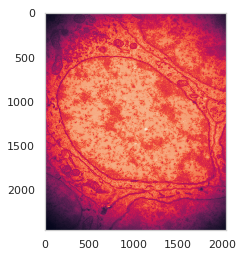

In [35]:
# Open the image
nuc_image_tif = Image.open(cell_path)
# Turn into a np array
nuc_image_np = uint_resize_gauss(np.array(nuc_image_tif), sigma=2)
plt.imshow(nuc_image_np)

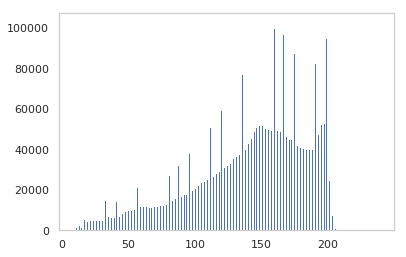

In [37]:
# Threshold of the image
plt.hist(nuc_image_np.flatten(), bins=200)
plt.show()

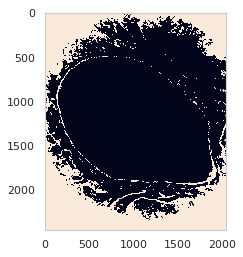

In [45]:
# Otsu thresh
nuc_thresh = np.invert(threshold_image(nuc_image_np, mode='otsu'))
plt.imshow(nuc_thresh)

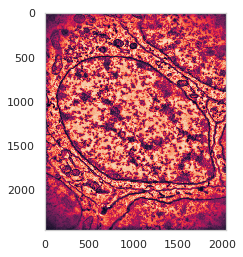

In [62]:
# Local contrast enhancement
clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(21,21))
nuc_image_clahe = clahe.apply(nuc_image_np)
plt.imshow(nuc_image_clahe)

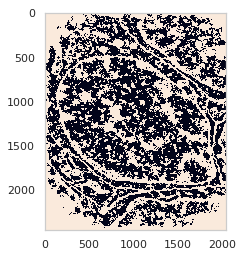

In [135]:
# Otsu on contrast enhanced image
nuc_clahe_thresh = np.invert(threshold_image(nuc_image_clahe, mode='otsu'))
plt.imshow(nuc_clahe_thresh)

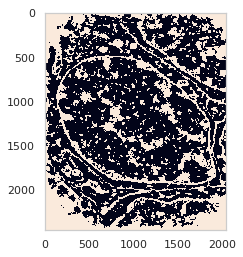

In [90]:
# Morphological opening (denoising)
nuc_clahe_open = get_opening(nuc_clahe_thresh, n_erode=3, n_dilate=2)
plt.imshow(nuc_clahe_open)

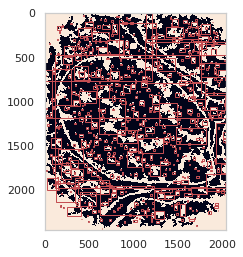

In [116]:
# Find all contours

contours, _ = cv2.findContours(nuc_clahe_open, 1, 2)
contour_largest, area_largest = get_largest_contour(contours=contours)

fig,ax = plt.subplots(1)
ax.imshow(nuc_clahe_open)
for contour in contours:
    x,y,w,h = cv2.boundingRect(contour)
    # Create a Rectangle patch
    rect = patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='r',facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)
    
plt.show()

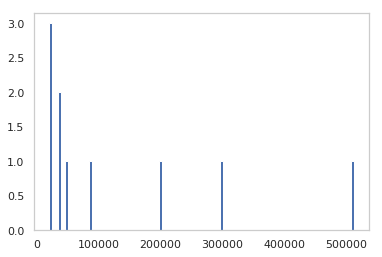

In [126]:
# Create a sorted list of largest contours by area

all_areas_dict = {cv2.contourArea(cnt) : cnt for cnt in contours}
all_areas_list_sorted = sorted(all_areas_dict.keys(),reverse=True)
largest_contours = [all_areas_dict[area] for area in all_areas_list_sorted]
plt.hist(all_areas_list_sorted[:10], bins=100)
plt.show()

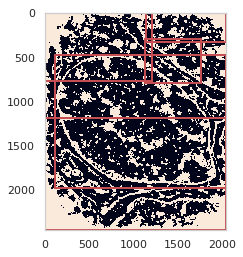

In [136]:
# Plot the largest contoursin bounding boxes

fig,ax = plt.subplots(1)
ax.imshow(nuc_clahe_open)
for contour in largest_contours[:5]:
    x,y,w,h = cv2.boundingRect(contour)
    # Create a Rectangle patch
    rect = patches.Rectangle((x,y),w,h,linewidth=2,edgecolor='r',facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)
    
plt.show()